In [1]:
from trends_core3d import *
import matplotlib.pyplot as plt
from intake import open_catalog
import dask
import cartopy.crs as ccrs

# Custom part for the ECV evaluator to read in the data 

In [2]:
# Here I use Python Intake for managing the reading of several datasets
cat = open_catalog('/home/crezees/projects/earthdata_reader/catalogs/sm_catalog.yml')
print(list(cat))

['era_interim_land', 'satellite_soil_moisture', 'esa_cci_sm_combined_v05.0', 'reanalysis_era5_single_levels', 'reanalysis_uerra_europe_soil_levels_uerra_harmonie']


In [3]:
# Read in CDS satellite soil moisture dataset
mydat = cat['esa_cci_sm_combined_v05.0']

# Although this method is called to_dask() it returns a Xarray dataset
mydat = mydat.to_dask()

# Reduce data size a little by taking every tenth grid cell in lat and in lon direction
mydat = mydat.sm[:,:,:]

# Since the operations are performed over the time axis, it is important to have only one chunk along the time axis. Other chunk-sizes should be choosen depending on number of cores available
mydat = mydat.chunk({'time': -1, 'lat' : 360, 'lon' : 720})

# Print the object to check chunksizes
print(mydat)

<xarray.DataArray 'sm' (time: 470, lat: 720, lon: 1440)>
dask.array<shape=(470, 720, 1440), dtype=float64, chunksize=(470, 360, 720)>
Coordinates:
  * lon      (lon) float32 -179.875 -179.625 -179.375 ... 179.625 179.875
  * lat      (lat) float32 89.875 89.625 89.375 ... -89.375 -89.625 -89.875
  * time     (time) datetime64[ns] 1978-11-15T12:00:00 1978-12-16 ... 2017-12-16
Attributes:
    long_name:        Volumetric Soil Moisture
    units:            m3 m-3
    _CoordinateAxes:  time lat lon


In [4]:
# Compute
mydat = mydat.compute(scheduler='processes')

In [5]:
mydat = mydat.groupby('time.year').mean('time').compute()

/net/exo/landclim/crezees/conda/envs/trends/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


> Some functions expect the 'time' coordinate to be available. 
> the groupby() operation changes the name of the time coordinate to 
> to become the 'year' coordinate, therefore, here it is changed back. 


In [7]:
mydat = mydat.rename({'year' : 'time'})

# Fraction of valid data for each gridpoint

In [8]:
validfraction = validfrac(mydat)
validfraction = validfraction.compute()

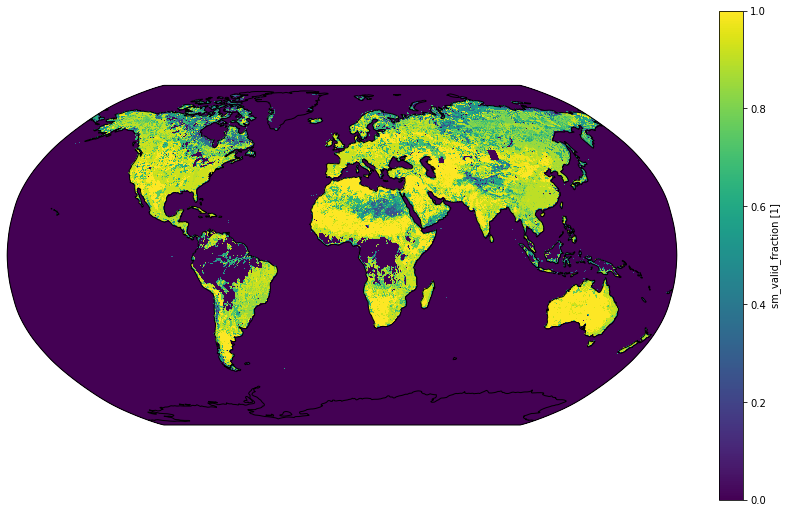

In [9]:
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111, projection=ccrs.Robinson())
validfraction.plot(ax=ax, transform=ccrs.PlateCarree(),robust=True) # Note that computation takes place at this place
ax.coastlines()

# Linear trend (where pvalue < 0.05 and valid_fraction > .8)

In [10]:
'units' in mydat.attrs

False

In [11]:
lintrend,linpvalue = linear_trend(mydat)
lintrend = lintrend.compute() # Force computation
linpvalue = linpvalue.compute() # Force computation

/net/exo/landclim/crezees/conda/envs/trends/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:116: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/net/exo/landclim/crezees/conda/envs/trends/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:126: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/net/exo/landclim/crezees/conda/envs/trends/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:128: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


# Linear trend (only 'significant')

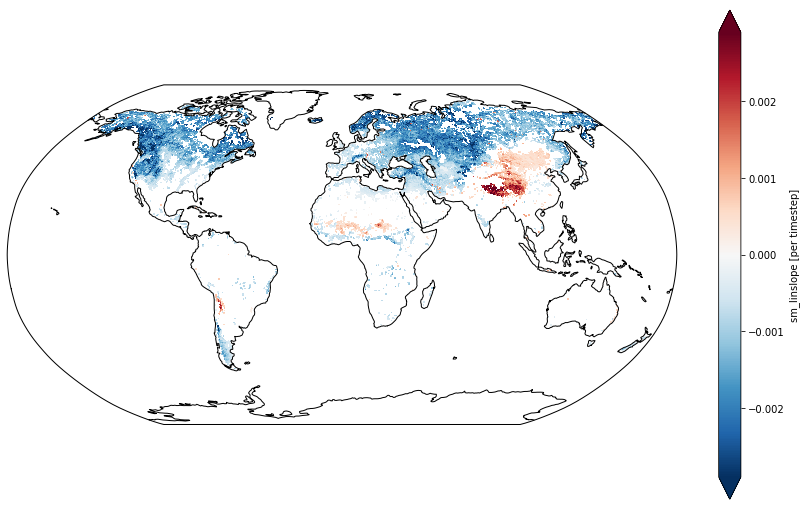

In [12]:
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111, projection=ccrs.Robinson())
lintrend.where((linpvalue < 0.05) & (validfraction > 0.8)).plot(ax=ax, transform=ccrs.PlateCarree(),robust=True)
ax.coastlines()

# Theilsen slope (where valid_fraction > 0.8)

/net/exo/landclim/crezees/conda/envs/trends/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/net/exo/landclim/crezees/conda/envs/trends/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/net/exo/landclim/crezees/conda/envs/trends/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


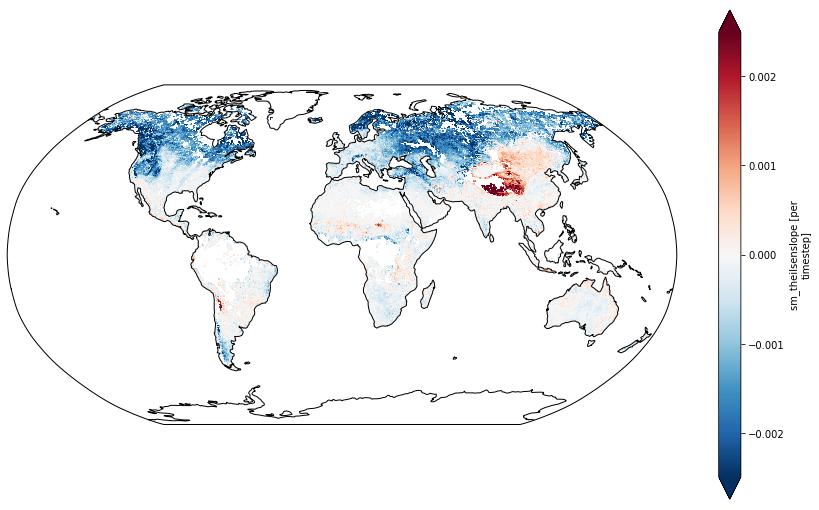

In [13]:
mydat = mydat.chunk({'time': -1, 'lat' : 36, 'lon' : 72})
theilsen_slope = theilsen_trend(mydat)
theilsen_slope = theilsen_slope.compute(num_workers=16)

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111, projection=ccrs.Robinson())
theilsen_slope.where(validfraction > 0.8).plot(ax=ax, transform=ccrs.PlateCarree(),robust=True)
ax.coastlines()

# Mann-Kendall trend test (where valid_fraction > 0.8)

In [14]:
mk_result = mannkendall(mydat).compute() # Like this the computation is forced.

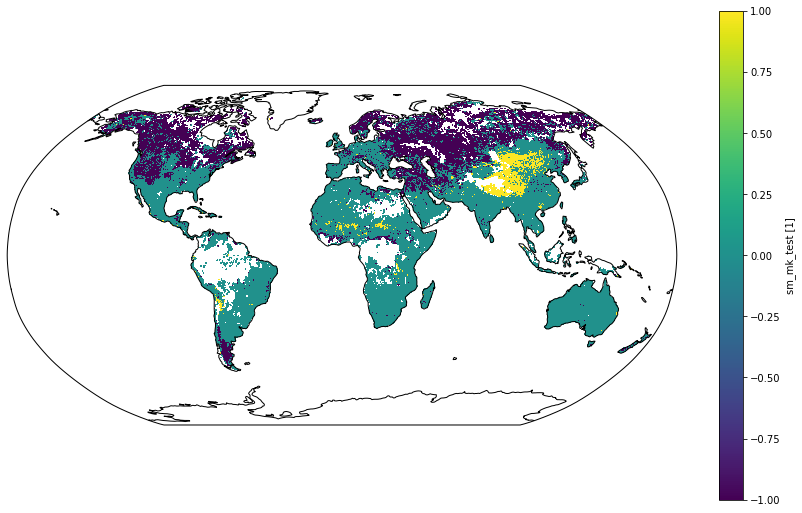

In [15]:
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111, projection=ccrs.Robinson())
mk_result.where(validfraction > 0.8).plot(ax=ax, transform=ccrs.PlateCarree(),robust=True,vmin=-1,vmax=1)
ax.coastlines()

# Remarks
This example notebook was created for demonstrating the functionality available in this trend framework. A good knowledge of both the dataset and the specific trend algorithm is essential for interpreting correctly the outcome of different trend tests.

# Data acknowledgement and references

The dataset that was used to create this example notebook was provided by the 'ESA CCI SM project' and is freely available on [this link](https://www.esa-soilmoisture-cci.org/) after registration and acceptance of the 'Terms and Conditions of data usage, and Personal Data Privacy Policy Statement'.

- Dorigo, W.A., Wagner, W., Albergel, C., Albrecht, F., Balsamo, G., Brocca, L., Chung, D., Ertl, M., Forkel, M., Gruber, A., Haas, E., Hamer, D. P. Hirschi, M., Ikonen, J., De Jeu, R. Kidd, R. Lahoz, W., Liu, Y.Y., Miralles, D., Lecomte, P. (2017). ESA CCI Soil Moisture for improved Earth system understanding: State-of-the art and future directions. In Remote Sensing of Environment, 2017, ISSN 0034-4257, https://doi.org/10.1016/j.rse.2017.07.001.
- Gruber, A., Dorigo, W. A., Crow, W., Wagner W. (2017). Triple Collocation-Based Merging of Satellite Soil Moisture Retrievals. IEEE Transactions on Geoscience and Remote Sensing. PP. 1-13. 10.1109/TGRS.2017.2734070.
- Liu, Y.Y., Dorigo, W.A., Parinussa, R.M., de Jeu, R.A.M. , Wagner, W., McCabe, M.F., Evans, J.P., van Dijk, A.I.J.M. (2012). Trend-preserving blending of passive and active microwave soil moisture retrievals, Remote Sensing of Environment, 123, 280-297, doi: 10.1016/j.rse.2012.03.014.